## General purpose geobody extraction 

**Inputs: generic file formats for input/output of seismic/horizon<br>
Outputs: Supervised training data for Machine Learning**

<br>
**2018 Salt Lake City Hackathon Project (May 18-20, 2018)**

_Nam Pham, Nathan Suurmeyer, Graham Brew_


In [1]:
###############################
# Standard Imports
###############################
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import Series, DataFrame
from time import sleep
import sys
import os
import string
import csv
% matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})  # To remove the annoying "Two many plots open" warning
plt.style.use('ggplot')                              # Make it look nice
%config InlineBackend.figure_format='retina'         # For high resolution screens
sns.set_context("talk")

###############################
# Import the DGI Python Toolkit
# The Following can all safely be deleted
###############################

if ("COVIZHOME" in os.environ):
    pydevkit_path = os.path.join(os.environ["COVIZHOME"],"etc", "pydevkit")
    sys.path.append(pydevkit_path)
elif ("EVHOME" in os.environ):
    pydevkit_path = os.path.join(os.environ["EVHOME"],"etc", "pydevkit")
    sys.path.append(pydevkit_path)
import dgi_devkit,dgi_util,dgi_proj,dgi_gridio,dgi_fileio,dgi_info
# If folder is not writeable, don't write bytecode
if (not dgi_util.is_writeable(pydevkit_path)):
    sys.dont_write_bytecode = True

## Set all inputs / outputs here


In [2]:
####
#    Input Seismic Volume, SEGY
####

input_seismic_file = './F3_entire.segy'


####
#    Input Smport the horizon pair to work on¶
#    Should be labled with inline, xline, and time/depth
####

# Very small pair
# base_channel = './tbase_ch_inlcrl.dat'
# top_channel = './top_ch_inlcrl_all.dat'

# Most interesting pair
base_channel = './topforsets_inlcrl_all.dat'
top_channel = './truncation_inlcrl_all.dat'

# Most devlopment done of this pair:
#base_channel = './MFS4_inlcrl_all.dat'
#top_channel = './FS8_inclcrl_all.dat'


####
#    Output Seismic / Geobody pickle names
####

out_seismic = './output_seismic.pkl'
out_geobody = './output_seismic.pkl'

In [3]:
def read_seismic_volume(input_file):
    from obspy.io.segy.segy import _read_segy
    input_file = './F3_entire.segy'
    stream = _read_segy(input_file, headonly=True)
    data = np.stack(t.data for t in stream.traces)
    seismic_data_shaped = data.reshape(651,951,462)
    return(seismic_data_shaped)

In [4]:
def import_horizons(top_channel, base_channel):

    with open(top_channel) as tsv:
        reader = csv.reader(tsv, delimiter="\t")
        temp_array = np.array(list(reader))
        array_top = temp_array.astype(np.float)

    with open(base_channel) as tsv:
        reader = csv.reader(tsv, delimiter="\t")
        temp_array = np.array(list(reader))
        array_base = temp_array.astype(np.float)
        
    return(array_top, array_base)

In [5]:
def array_qc(array_top, array_base):
    print(array_top.shape)
    print(array_base.shape)
    print(np.amin(array_top[:,0]))
    print(np.amax(array_top[:,0]))
    print(np.amin(array_top[:,1]))
    print(np.amax(array_top[:,1]))
    print(np.amin(array_base[:,0]))
    print(np.amax(array_base[:,0]))
    print(np.amin(array_base[:,1]))
    print(np.amax(array_base[:,1]))
    #plt.scatter(array_top[:,0], array_top[:,1]);
    plt.scatter(array_base[:,0], array_base[:,1]);
    return

In [6]:
def array_tops(array_top, array_base):
    i_top = array_top[:,0] - np.amin(array_top[:,0])
    i_top = i_top.astype(np.int)
    print(i_top)

    j_top = array_top[:,1] - np.amin(array_top[:,1])
    j_top = j_top.astype(np.int)
    print(j_top) 

    i_base = array_base[:,0] - np.amin(array_top[:,0])
    i_base = i_base.astype(np.int)
    print(i_base)

    j_base = array_base[:,1] - np.amin(array_top[:,1])
    j_base = j_base.astype(np.int)
    print(j_base) 
    
    return(i_top, i_base, j_top, j_base)

### Work starts here

In [7]:
# Do all the setup work

if True:    # can take a long time
    seismic_data_shaped = read_seismic_volume(input_seismic_file)
    
array_top, array_base = import_horizons(top_channel, base_channel)

if False:    # Used Only for QC of inputs, not required
    array_qc(array_top, array_base)

i_top, i_base, j_top, j_base = array_tops(array_top, array_base)

[  0   0   0 ... 644 644 644]
[  0   1   2 ... 944 945 946]
[  2   2   2 ... 643 643 643]
[  2   3   4 ... 460 461 462]


In [8]:
s_top = np.zeros([645,947])
s_base = np.zeros([645,947])

s_top[s_top==0] = np.nan
s_base[s_base==0] = np.nan

In [9]:
s_top[i_top,j_top] = array_top[:,2]
s_base[i_base,j_base] = array_base[:,2]

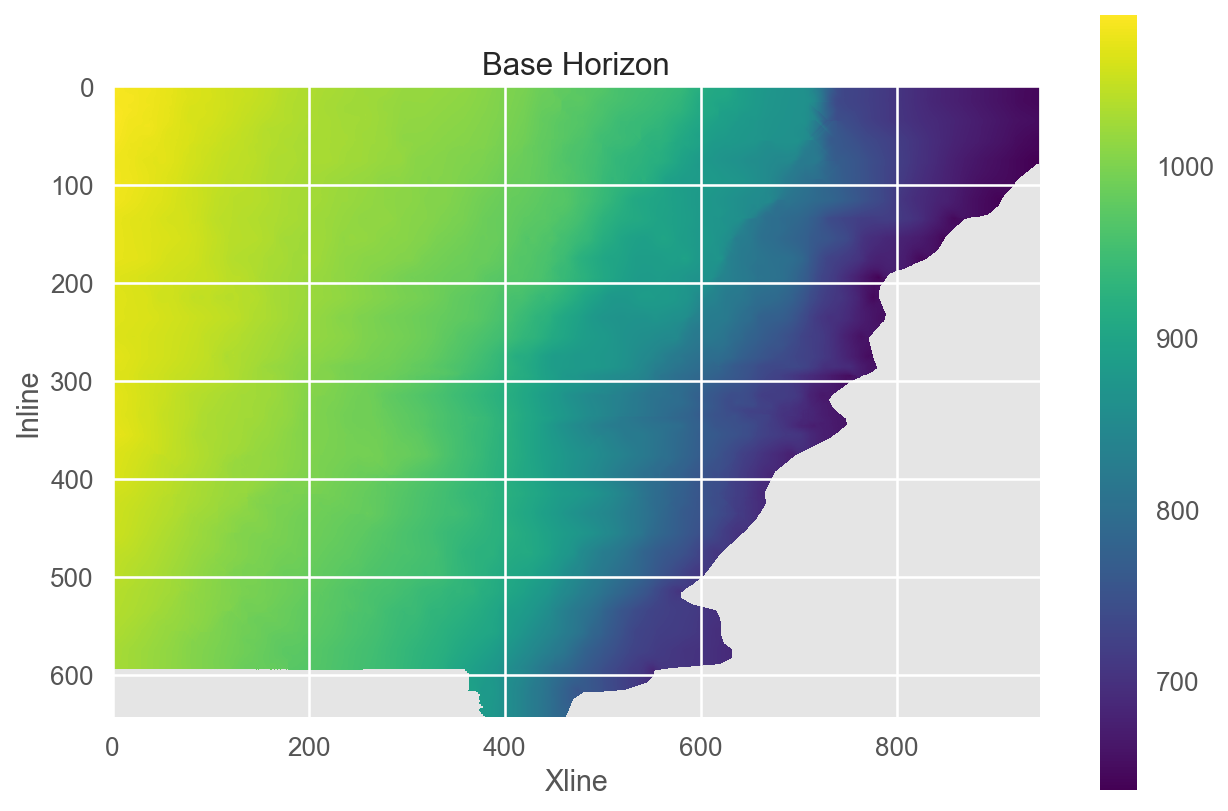

In [10]:
plt.imshow(s_base, cmap='viridis');
plt.colorbar();
plt.xlabel("Xline");
plt.ylabel("Inline");
plt.title("Base Horizon");

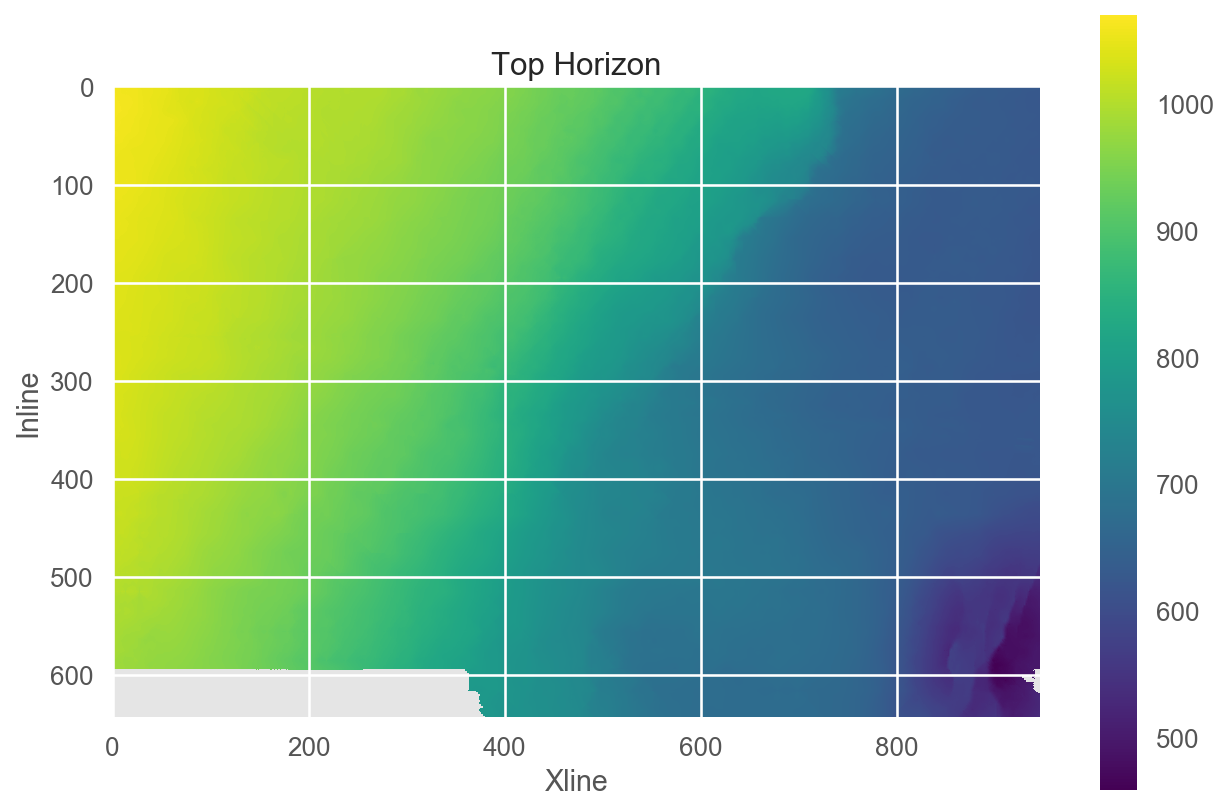

In [11]:
plt.imshow(s_top, cmap='viridis')
plt.colorbar()
plt.xlabel("Xline");
plt.ylabel("Inline");
plt.title("Top Horizon");

In [12]:
p = seismic_data_shaped.shape[2]  # Number of samples per trace

In [13]:
m = int(s_top.shape[0])
n = int(s_base.shape[1])
print(m, n)

645 947


In [14]:
dt = 0.004 * 1000
def idxs_surf(s):
    idxs = (s/dt)
    idxs[idxs<0]=np.nan
    idxs = idxs.astype(np.int)
    return idxs

In [15]:
c = np.zeros([m,n,p])

In [16]:
xx1 = np.expand_dims(idxs_surf(s_top),2)
yy1 = np.tile(xx1,p)
yy1.shape

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(645, 947, 462)

In [17]:
xx2 = np.expand_dims(idxs_surf(s_base),2)
yy2 = np.tile(xx2,p)
yy2.shape

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(645, 947, 462)

In [18]:
t = np.arange(p)
c = np.tile(t,m)
cc = np.tile(c,n).reshape(m,n,p)
cc.shape

(645, 947, 462)

In [19]:
#plt.imshow(yy1[200].T, cmap='viridis');

In [20]:
# The clever cells that picks the geobody between top and base
output_array = np.where((cc>yy1) & (cc<yy2),1,0)
output_array[0]=0

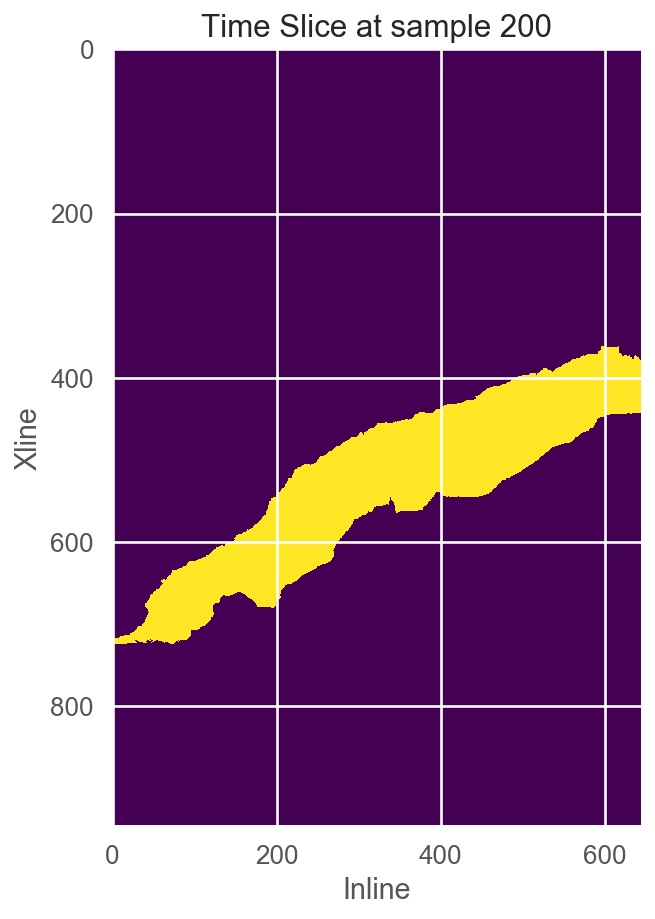

In [21]:
time = 200
plt.imshow(output_array[:,:,time].T, clim=(0,1), cmap='viridis')
plt.xlabel("Inline");
plt.ylabel("Xline");
plt.title("Time Slice at sample " + str(time));

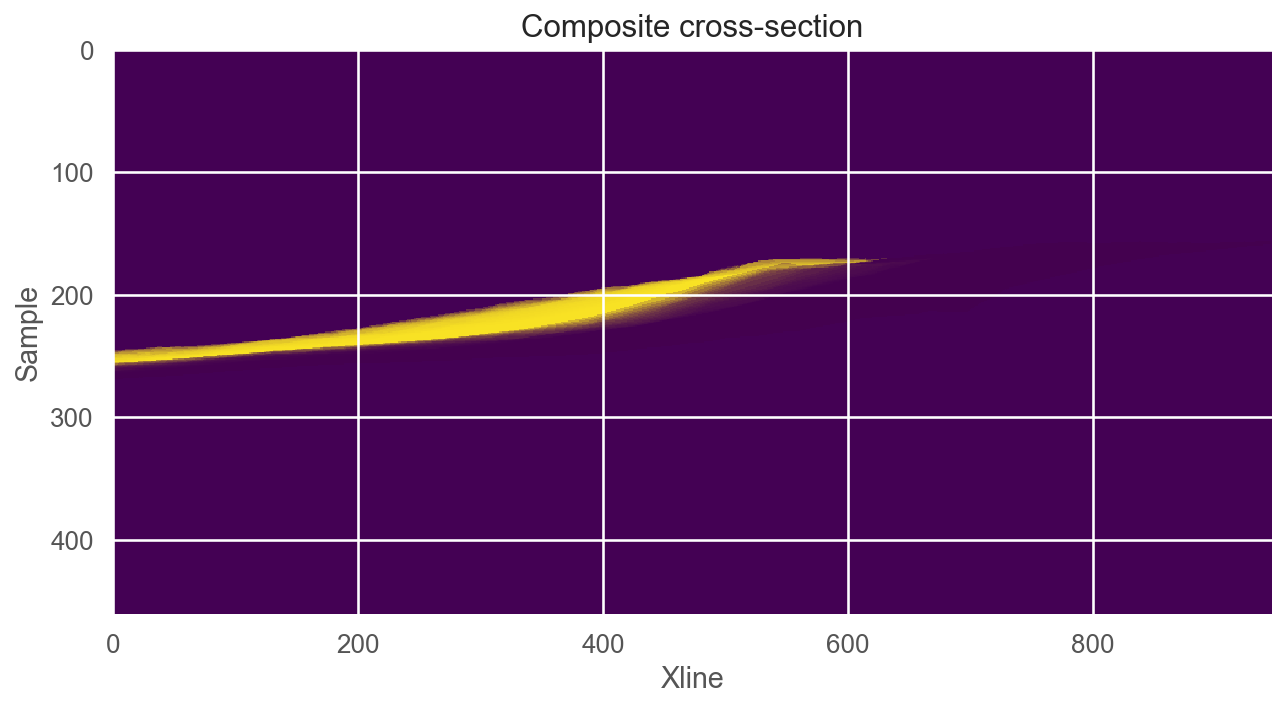

In [22]:
for line in range(0,595,10):
    plt.imshow(output_array[line].T, clim=(0,1), cmap='viridis', alpha=0.2)
plt.xlabel("Xline");
plt.ylabel("Sample");
plt.title("Composite cross-section");

In [23]:
# Decimate the geobody to make it more mangabable
output_array_dec = output_array[::5,::5,::2]
output_array_dec.shape

(129, 190, 231)

### Plot in 3D 

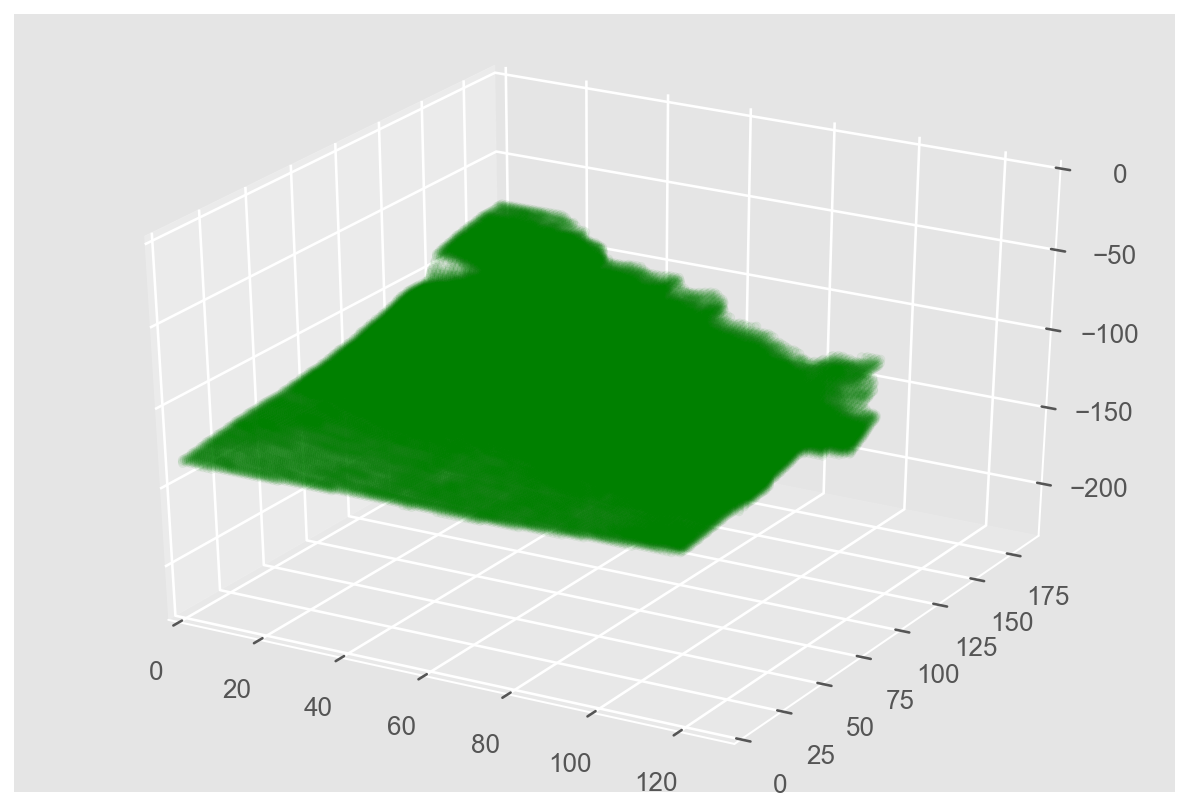

In [24]:
from mpl_toolkits.mplot3d import Axes3D

i, j, k = np.where(output_array_dec == 1)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(i, j, -k, zdir='z', c= 'green', alpha=0.05)
ax.set_xlim3d(0,130)
ax.set_ylim3d(0,190)
ax.set_zlim3d(-230,-0);

In [25]:
# Decimate the seismic to make it more mangabable
seismic_data_dec = seismic_data_shaped[::5,::5,::2]
seismic_data_dec.shape

(131, 191, 231)

In [26]:
# Optional output in DGI format for display via ASCII data
if False:
    
    ! cp DGI_Header.txt decimated_output.pdat
    file = open('./decimated_output.pdat','a') 
    for row in range(output_array_dec[:,0,0].shape[0]):
        for column in range(output_array_dec[0,:,0].shape[0]):
            for level in range(output_array_dec[0,0,:].shape[0]):
                out = str(row)+"\t"+str(column)+'\t'+str(level)+'\t'+str(output_array_dec[row,column,level])+'\t'+str(row+1)+'\t'+str(column+1)+'\t'+str(level+1)+'\n'
                file.write(out)   
    file.close() 

    execLine = ["-o", "decimated.3grd", "decimated_output.pdat"]
    dgi_devkit.dgi_import(execLine);

    ! cp DGI_Header2.txt decimated_seismic_output.pdat
    file = open('./decimated_seismic_output.pdat','a') 
    for row in range(seismic_data_dec[:,0,0].shape[0]):
        for column in range(seismic_data_dec[0,:,0].shape[0]):
            for level in range(seismic_data_dec[0,0,:].shape[0]):
                out = str(row)+"\t"+str(column)+'\t'+str(level)+'\t'+str(seismic_data_dec[row,column,level])+'\t'+str(row+1)+'\t'+str(column+1)+'\t'+str(level+1)+'\n'
                file.write(out)   

    file.close() 

    execLine = ["-o", "decimated_seismic.3grd", "decimated_seismic_output.pdat"]
    dgi_devkit.dgi_import(execLine);

In [27]:
import io
import base64
from IPython.display import HTML

video = io.open('rotation.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

### Output Geobodies and Input SEGY as Pickles for ML Training


In [28]:
np.save(out_seismic, seismic_data_shaped, allow_pickle=True)
np.save(out_geobody, output_array, allow_pickle=True)

### Output Geobodies and Input SEGY as SEGY for QC/Visualization (under development!!)

In [29]:
data_slice = np.array(output_array[500], dtype='f')
data_volume = np.array(output_array, dtype='f')
type(data_volume[0,0])
data_volume.shape

(645, 947, 462)

In [30]:
from obspy.core import AttribDict
from obspy.core import Stats

from obspy.core import Trace, Stream
from obspy.io.segy.segy import SEGYBinaryFileHeader
from obspy.io.segy.segy import SEGYTraceHeader

stream = Stream()

for _j in range(3):   # for xlines
    for _i in range(data_slice.shape[0]):
        trace = Trace(data=data_volume[_j][_i])

        # Attributes in trace.stats will overwrite everything in
        # trace.stats.segy.trace_header
        trace.stats.delta = 0.01
        # SEGY does not support microsecond precision! Any microseconds will
        # be discarded.
        #trace.stats.starttime = UTCDateTime(2011,11,11,11,11,11)

        # If you want to set some additional attributes in the trace header,
        # add one and only set the attributes you want to be set. Otherwise the
        # header will be created for you with default values.
        if not hasattr(trace.stats, 'segy.trace_header'):
            trace.stats.segy = {}
        trace.stats.segy.trace_header = SEGYTraceHeader()
        trace.stats.segy.trace_header.trace_sequence_number_within_line = _i + 1
        trace.stats.segy.trace_header.trace_sequence_number_within_xline = _j + 1   ######## does this work??? Add a loop?
        trace.stats.segy.trace_header.receiver_group_elevation = 444

        # Add trace to stream
        stream.append(trace)

# A SEGY file has file wide headers. This can be attached to the stream
# object.  If these are not set, they will be autocreated with default
# values.
stream.stats = AttribDict()
stream.stats.textual_file_header = 'Textual Header!'
stream.stats.binary_file_header = SEGYBinaryFileHeader()
stream.stats.binary_file_header.trace_sorting_code = 5

print("Stream object before writing...")
print(stream)

stream.write("TEST.sgy", format="SEGY", data_encoding=1,
             byteorder=sys.byteorder) # encode 1 for IBM, 5 for IEEE
print("Stream object after writing. Will have some segy attributes...")
print(stream)

Stream object before writing...
2841 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.610000Z | 100.0 Hz, 462 samples
...
(2839 other traces)
...
Seq. No. in line:  947 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.610000Z | 100.0 Hz, 462 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
Stream object after writing. Will have some segy attributes...
2841 Trace(s) in Stream:

Seq. No. in line:    1 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.610000Z | 100.0 Hz, 462 samples
...
(2839 other traces)
...
Seq. No. in line:  947 | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:04.610000Z | 100.0 Hz, 462 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [31]:
dt = 4 / 1e6

out = Stream()                      # Make a new Stream object, basically an empty list-like thing.
for t in data_slice:                # Loop over all trace-like things in the similarity array.
    header = {'delta': dt}          # Make a header for the trace; ObsPy needs this.
    trace = Trace(t, header=header) # Make the ObsPy Trace with the data and the header.
    out.append(trace)               # Append the Trace to the Stream.

In [32]:
out.write('./out.sgy', format='SEGY', data_encoding=5)  # encode 1 for IBM, 5 for IEEE

C:\Anaconda3\lib\site-packages\obspy\io\segy\core.py:357: UserWarning: CREATING TRACE HEADER
  warnings.warn("CREATING TRACE HEADER")
